In [1]:
import sys

In [2]:
sys.path.append("C:\Users\Miguel\workspace\Thesis\geobyes")

In [3]:
import geobayes_simple as gs
from matplotlib import pyplot as plt

In [4]:
%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


####Function to plot posteriors

In [5]:
def plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axe_position):
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = axe_position, plot_faults= True, plot_points= False, alpha = 1) # Need to make it transparent!!! 
    

### Goal of the notebook

I want to make the position of alpha and its dip dependent of observed data. We set as prior normal distributions for both but we want to know the mean and tau of both values isn't it?

So the hard data we get are position of alpha in 2D and some dips, that is what we set in the geomodeller I guess. So lets create the synthetic data:

For alpa x axe goes from 0 to 2000 and lets make the sythetic data around 0

(4L,)


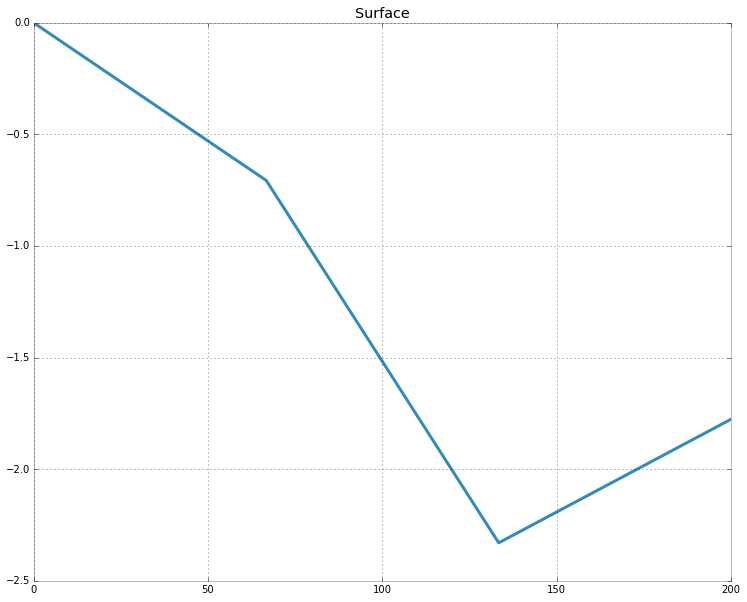

In [13]:
alpha_position_x = np.linspace(0,200,4)
alpha_position_y = np.zeros(4)
print np.shape(alpha_position_x)
for i in range(1, 4):
    alpha_position_y[i] = pm.rnormal(alpha_position_y[i - 1], 2)
plt.plot(alpha_position_x, alpha_position_y, lw=3)
plt.title("Surface")

## Simplier model
####Setting priors and models

In [ ]:
print alpha_position_y.mean()
print alpha_position_y.std()

In [50]:
#a = pm.Normal('a', 0, 0.00001)
#b = pm.Normal('b', 0, 0.0001)

# Precision of normal distribution of prices
#tau = pm.Gamma('tau', alpha=0.1, beta=0.1)



alpha = pm.Normal("alpha", 0,0.0001) 
beta = pm.Normal("beta", -200, 0.005, value=0)
gamma = pm.Normal("gamma", -300, 0.005, value = 0)

#observed = pm.Normal("obs", alpha.mean, 1/alpha.std**2, value = alpha_position_y, observed = True)

observed = pm.Normal("obs", alpha, 0.1,  value = alpha_position_y, observed = True)
#print alpha.value
print beta.value


#MODEL!!
model = pm.Model([ alpha, beta, gamma])

0.0


0.377331996753


(0, 1)

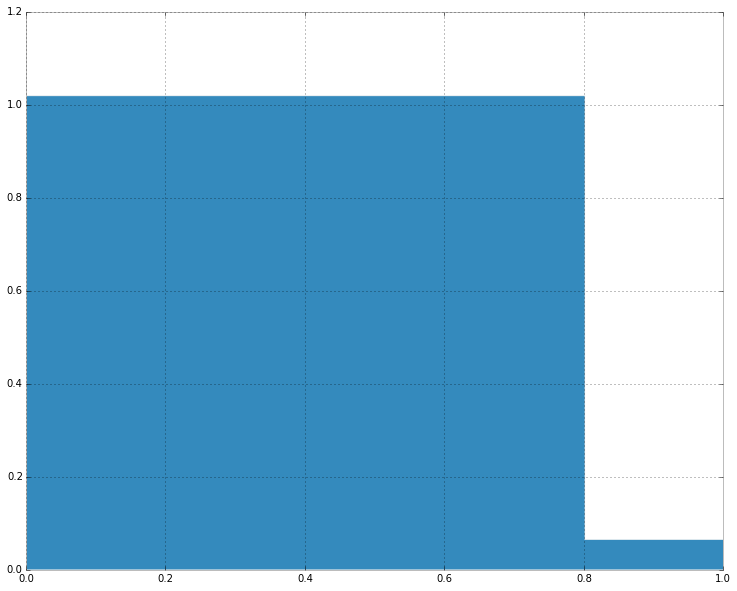

In [33]:
print tau.random()
#print alpha.random
#print alpha.value
samples = [tau.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.xlim([0,1])

In [51]:
M = pm.MCMC(model)

M.sample(iter=5000, burn = 80)


 [-----------------100%-----------------] 5000 of 5000 complete in 0.5 sec

In [52]:
M.summary()


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-199.936]]     [[ 14.023]]      [[ 0.177]]   [-228.719 -173.916]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-227.685]]     [[-209.639]]    [[-199.609]]   [[-190.647]]  [[-172.377]]
	

gamma:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-299.848]]     [[ 14.266]]      [[ 0.19]]    [-326.881 -271.227]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-327.755]]     [[-309.534]]    [[-300.061]]   [[-290.285]]  [[-271.77]]
	

alpha:
 
	Mean             SD               MC Error        95% HPD interval
	---------

In [ ]:
plot(M)

In [38]:
#alpha_samples = M.trace('a')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)

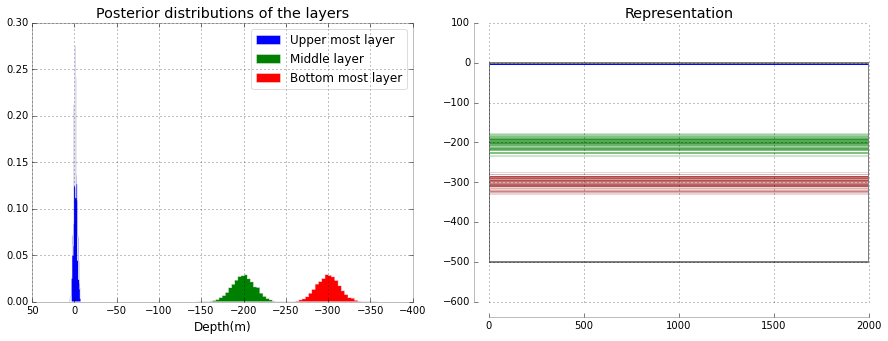

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True, color = "b")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
for alpha, beta, gamma in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (0,0.),
                                    'fault_w_dip' : 0,
                                    'fault_e_pos' : (0.,0.),
                                    'fault_e_dip' : 0.},
                        'layers' : {3 : {'w' :(250., -200.),
                                         
                                                 'c' : (1000., -400.),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., -400.),
                                                 'c' : (1000., -600.),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., -600.),
                                                 'c' : (1000., -800.),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : 0.000001,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 500. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= False, plot_points= False, alpha = 0.3) # Need to make it transparent!!!

## Complex model

#### Setting priors and models

In [ ]:
#Priors

alpha = pm.Normal("alpha", 0, 0.00005, value = alpha_position_y, observed = True)
#print alpha.value

layer_dip = pm.Normal("layer_dip", 5, 0.05)



thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.005) # a lot of uncertainty so the constrains are necessary
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.005)

offset = pm.Normal("offset", 500, 0.005)


fault_e_dip = pm.Normal("fault_e_dip", -70, 0.005, value = -70)
fault_w_dip = pm.Normal("fault_w_dip", 70, 0.005, value = 70)


@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2

# Constraints -> probability


@pm.potential
def offset_negative_constraint(offset = offset):
    if offset < 0:
        return -np.inf
    return 0

@pm.potential
def faults_limits(fault_e_dip = fault_e_dip, fault_w_dip = fault_w_dip):
    if fault_e_dip < -90 or fault_w_dip > 90 :
        return -np.inf
    if fault_e_dip > 0 or fault_w_dip < 0:
        return -np.inf
    return 0


@pm.potential
def offset_below_faults_constraint(fault_e_dip = fault_e_dip, fault_w_dip = fault_w_dip,
                                   offset = offset, beta =  beta, gamma = gamma):
    fault_intersect = 1100/(np.tan(np.radians(90+fault_e_dip))+np.tan(np.radians(90-fault_w_dip)))       #1100 Distance of the faults at surface for now

#    print "fault",fault_intersect
 #   print  "layers", fault_intersect-offset-gamma, fault_intersect-offset-beta
   
    #print "Hasta aqui no llega no?", (fault_intersect-offset-beta) < 0
    #print "Hasta qui?", (fault_intersect-offset-gamma) < 0
    if any((fault_intersect-offset-beta) < 0) or any((fault_intersect-offset-gamma) < 0):
    
        return -np.inf
       
    else:
     #   print " pero que oohh"
        return 0



#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2,
                  offset, layer_dip, fault_e_dip, fault_w_dip, 
                  faults_limits, offset_negative_constraint, offset_below_faults_constraint])

#### PyMC simulation

In [ ]:
M = pm.MCMC(model)
M.sample(iter=5000, burn = 800)

#### Representation

In [ ]:
s = -9

gamma_samples, gamma_samples_all = M.trace('gamma')[s:], M.trace('gamma')[:]
alpha_samples, alpha_samples_all = M.trace('alpha')[s:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[s:], M.trace("beta")[:]
offset_samples, offset_samples_all = M.trace("offset")[s:], M.trace("offset")[:]
layer_dip, layer_dip_all = M.trace("layer_dip")[s:], M.trace("layer_dip")
fault_e_dip, fault_e_dip_all = M.trace("fault_e_dip")[s:], M.trace("fault_e_dip")
fault_w_dip, fault_w_dip_all = M.trace("fault_w_dip")[s:],M.trace("fault_w_dip")

parameters = zip(alpha_samples, beta_samples, gamma_samples, offset_samples, layer_dip, fault_e_dip, fault_w_dip)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all, offset_samples_all, layer_dip_all, fault_e_dip_all, fault_w_dip_all)





fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
ax[1].set_ylim([-1000,0])
for  alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= True , plot_points= False, alpha = 0.3) # Need to make it transparent!!!
    
    
i = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)

for alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip  in parameters:
    plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axs[i- 3*(i/3),i/3])
    axs[i- 3*(i/3),i/3].set_xlim([0,2000])
    axs[i- 3*(i/3),i/3].set_ylim([-1000,0])
    i += 1

In [ ]:
plot(M)